# Machine Learning for Thyroid Cancer Diagnosis.
##  Part 2: Logistic regression
**The project was done with Rajiv Krishnakumar and Raghu Mahajan.**

The essential goal was to predict thyroid cancer given gene expressions. A key hope is to definitively predict benign samples; this helps to avoid unnecessary surgeries, which often turn out to be much more problematic to a patient's health, than the thyroid cancer itself.


- The data used here is pre-normalized, to mean zero and standard deviation 1. 
- The essentials of the data set are 265 patients whose biopsies were inconclusive, each with 173 reported gene expression levels. 
- There were a further 102 patients with 'conclusive' biopsies - i.e. a human determination of benign vs. malignant, to give 367 total patients.

Here is an abstract from our final report:

*We investigate the use of high throughput gene expression data in the diagnosis of thyroid cancers. Using logistic regression and support vector machines (SVMs), we develop a classifier which gives similar performance (89% sensitivity and 80% specificity) to the currently best- known classifier, but uses significantly fewer features. We used two different techniques, principal components analysis and mutual information score, to select features. The results do not depend significantly on which method is used for feature selection.*

The breakdown of topics covered in each notebook is as follows:
1. Data visualization, including PCA and tSNE visualizations.
2. Logistic regression, with feature selection using different regularizers or different numbers of Principal components.
3. SVMs with and without box constraints, and also using different kernel functions.

In [24]:
#As usual import some modules and import the dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#import the data and look at it
X = pd.read_csv("data/normalized_data_265.csv", header =None)
y = pd.read_csv("data/outcome_265.csv", header = None)


X_full = pd.read_csv("data/normalized_data_367.csv", header =None)
y_full = pd.read_csv("data/outcome_367.csv", header = None)



#Now turn these into numpy arrays to avoid problems with pandas dataframes
X = X.as_matrix()
y = y.as_matrix().reshape(len(y))
X_full = X_full.as_matrix()
y_full = y_full.as_matrix().reshape(len(y_full))


## Logistic regression 

A simple and straightforward first pass is always a logistic regression.

In [25]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression



#First perform a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print "-----Results of train-test split-----"
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)




#Now perform the logistic regression
logit_bare = LogisticRegression(random_state = 1, solver = 'liblinear')
logit_bare.fit(X_train, y_train)


print ""
print "-----Logistic Regression-----"
print ""
print "Training accuracy: ",logit_bare.score(X_train,y_train)
print "Test set accuracy: ",logit_bare.score(X_test,y_test)

-----Results of train-test split-----
(212, 173)
(212,)
(53, 173)
(53,)

-----Logistic Regression-----

Training accuracy:  1.0
Test set accuracy:  0.849056603774


Ok - there is clearly some overfitting going on. We have 100% accuracy on the training set, but 70-80% accuracy on the test set. Let's break it down further by looking at commonly used metrics in biology:

$ \text{sensitivity} = \frac{\text{true_positive}}{\text{actual_condition_positive}}$ and 
$ \text{specificity} = \frac{\text{true_negative}}{\text{ actual_condition_negative}}$

In [26]:
from sklearn.metrics import confusion_matrix

y_pred_test = logit_bare.predict(X_test)
y_pred_full = logit_bare.predict(X)

confusion_test = confusion_matrix(y_test,y_pred_test)
confusion_full = confusion_matrix(y,y_pred_full)

print "Test Specificity =", confusion_test[0,0]/(1.0*(confusion_test[0,0] + confusion_test[0,1]))
print "Test Sensitivity =", confusion_test[1,1]/(1.0*(confusion_test[1,0] + confusion_test[1,1]))

print "Total Specificity =", confusion_full[0,0]/(1.0*(confusion_full[0,0] + confusion_full[0,1]))
print "Total Sensitivity =", confusion_full[1,1]/(1.0*(confusion_full[1,0] + confusion_full[1,1]))

Test Specificity = 0.906976744186
Test Sensitivity = 0.6
Total Specificity = 0.977777777778
Total Sensitivity = 0.952941176471


## Logistic regression with L1 and L2 regulators.

To avoid overfitting, we should introduce a regulator. Here we use GridSearchCV to loop over L1 and L2 type regulators, of different strengths, and find the best model

In [32]:
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV

logistic = linear_model.LogisticRegression()
parameters = {'penalty':('l1', 'l2'), 'C':np.logspace(-4, 4, 3)}

estimator = GridSearchCV(logistic,parameters, cv = 5)
estimator.fit(X,y)

print "Best Paramters: ", estimator.best_params_



y_pred = estimator.best_estimator_.predict(X)
confusion= confusion_matrix(y,y_pred)

y_pred_full = estimator.best_estimator_.predict(X_full)
confusion_full = confusion_matrix(y_full,y_pred_full)
print ""
print "-----Accuracies on Indeterminate samples (265 Patients)-----"
print "Final accuracy: ",estimator.best_estimator_.score(X,y)
print "Specificity =", confusion[0,0]/(1.0*(confusion[0,0] + confusion[0,1]))
print "Sensitivity =", confusion[1,1]/(1.0*(confusion[1,0] + confusion[1,1]))
print ""
print "-----Accuracies on Full Data Set (367 Patients)-----"
print "Final accuracy: ",estimator.best_estimator_.score(X_full,y_full)
print "Total Specificity, full data set =", confusion_full[0,0]/(1.0*(confusion_full[0,0] + confusion_full[0,1]))
print "Total Sensitivity, full data set =", confusion_full[1,1]/(1.0*(confusion_full[1,0] + confusion_full[1,1]))

Best Paramters:  {'penalty': 'l1', 'C': 1.0}

-----Accuracies on Indeterminate samples (265 Patients)-----
Final accuracy:  0.969811320755
Specificity = 0.994444444444
Sensitivity = 0.917647058824

-----Accuracies on Full Data Set (367 Patients)-----
Final accuracy:  0.931880108992
Total Specificity, full data set = 1.0
Total Sensitivity, full data set = 0.825174825175


In [33]:
#An l1 regulator will lead to an automatic reduction 
# in the number of features used by the logistic regression.
#Let us count the number of features used:
np.count_nonzero(estimator.best_estimator_.coef_)

79

### Guarding against overfitting
So the above numbers look really great, but just to check that we're not overfitting, let's do a train-test split once more.

In [39]:
#First perform a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#Train on the training set
logistic = linear_model.LogisticRegression()
parameters = {'penalty':('l1', 'l2'), 'C':np.logspace(-4, 4, 3)}

estimator = GridSearchCV(logistic,parameters, cv = 8)
estimator.fit(X_train,y_train)

#Now use the test set
print "Best Paramters: ", estimator.best_params_
print "Train accuracy: ",estimator.best_estimator_.score(X_test,y_test)
print "Test accuracy: ",estimator.best_estimator_.score(X_test,y_test)


y_pred_test = estimator.best_estimator_.predict(X_test)
confusion_test = confusion_matrix(y_test,y_pred_test)

print "Test Set Specificity =", confusion_test[0,0]/(1.0*(confusion_test[0,0] + confusion_test[0,1]))
print "Test Set Sensitivity =", confusion_test[1,1]/(1.0*(confusion_test[1,0] + confusion_test[1,1]))

Best Paramters:  {'penalty': 'l2', 'C': 1.0}
Train accuracy:  0.77358490566
Test accuracy:  0.77358490566
Test Set Specificity = 0.825
Test Set Sensitivity = 0.615384615385


So maybe those numbers weren't that great after all!?

## PCA + Logistic regression pipeline
We can adopt an *even more*  more principled approach by first doing PCA on the bare data, then logistic regression on this.

I do this by following the python example of "Pipeline" - where we use GridSearchCV to apply cross validation and search over multiple values of pca components and logistic regression penalties.

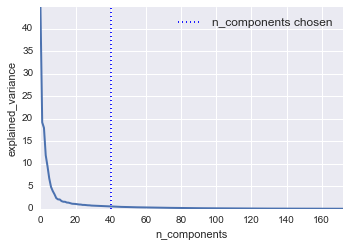

Best Paramters:  {'logistic__C': 1.0, 'pca__n_components': 40}
Final accuracy:  0.88679245283
Total Specificity = 0.95
Total Sensitivity = 0.752941176471


In [41]:
from sklearn import decomposition, linear_model
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])



###############################################################################
# Plot the PCA spectrum
pca.fit(X)

plt.figure(1, figsize=(6, 4))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance')

###############################################################################
# Prediction

n_components = [20, 40, 60, 80, 100, 120, 140]
Cs = np.logspace(-4, 4, 3)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X, y)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

print "Best Paramters: ", estimator.best_params_
print "Final accuracy: ",estimator.best_estimator_.score(X,y)


y_pred_full = estimator.best_estimator_.predict(X)
confusion_full = confusion_matrix(y,y_pred_full)

print "Total Specificity =", confusion_full[0,0]/(1.0*(confusion_full[0,0] + confusion_full[0,1]))
print "Total Sensitivity =", confusion_full[1,1]/(1.0*(confusion_full[1,0] + confusion_full[1,1]))